In this notebook you can run all three models for the crossbar dataset. The models are:
  - Discrete (Run dynamics and update at the equilibrium point)
  - Continuous (Run dynamics and update at every time step)
  - Asynchronous (Run dynamics and update at every time step, but only update neurons that satisfy the async constraint)

You can set the following variables in each simulation:
  - N_E - number of neurons
  - N_X - sqrt of input frame size
  - dt - learning rate
  - T_max - simulation time

The last block of the notebook plots the receptive fields of the neurons and if it shows bars, then the model has successfully learned a factiorization of the input data.
  

In [2]:
import jax.numpy as np
from jax import random
import numpy as onp
import matplotlib.pyplot as plt

In [16]:
def key():
    seed = onp.random.randint(0, 1000000)
    return random.PRNGKey(seed)

def stripes_bars(N_X):
    X = np.zeros((N_X, N_X))
    i = random.randint(key(), (2,), 0, N_X)
    X = X.at[i[0], :].set(1)
    X = X.at[:, i[1]].set(1)
    return X

In [20]:
#discrete learning

#set params
N_E = 100 #number of neurons
N_X = 5 #change the input frame size
dt = 0.01 #learning rate
T_max = 1000000 # simulation time


#initialize the network
W = random.exponential(key(), (N_E, N_X * N_X)) / np.sqrt(N_E)
M = random.exponential(key(), (N_E, N_E)) / np.sqrt(N_E)
y = random.normal(key(), (N_E,))
y_r = np.maximum(y, 0)
X = stripes_bars(N_X)
yy = []


for t in range(T_max):
    #compute dynamics
    y = y + dt * (np.dot(W, X.flatten()) - np.dot(M, y_r))
    y_r = np.maximum(y, 0)
    yy.append(y_r[:100])

    #update weights at the stable state
    if t % 500 == 0:
        W = W + dt * (np.outer(y_r, X.flatten()) - W)
        M = M + dt * (np.outer(y_r, y_r) - M)
        X = stripes_bars(N_X)


In [ ]:
#continuous learning

#set params
N_E = 100 #number of neurons
N_X = 5 #change the input frame size
dt = 0.001 #learning rate
T_max = 1000000 # simulation time


#initialize the network
W = random.exponential(key(), (N_E, N_X * N_X)) / np.sqrt(N_E)
M = random.exponential(key(), (N_E, N_E)) / np.sqrt(N_E)
y = random.normal(key(), (N_E,))
y_r = np.maximum(y, 0)
X = stripes_bars(N_X)
yy = []

for t in range(T_max):
    #compute dynamics
    y = y + dt * (np.dot(W, X.flatten()) - np.dot(M, y_r))
    y_r = np.maximum(y, 0)
    yy.append(y_r[:100])

    #update weights at the stable state
    W = W + dt * (np.outer(y_r, X.flatten()) - W)
    M = M + dt * (np.outer(y_r, y_r) - M)
    X = stripes_bars(N_X)

In [ ]:
#asynchrosnous learning

#set params
N_E = 100 #number of neurons
N_X = 5 #change the input frame size
dt = 0.01 #learning rate
T_max = 1000000 # simulation time


#initialize the network
W = random.exponential(key(), (N_E, N_X * N_X)) / np.sqrt(N_E)
M = random.exponential(key(), (N_E, N_E)) / np.sqrt(N_E)
y = random.normal(key(), (N_E,))
y_r = np.maximum(y, 0)
X = stripes_bars(N_X)
yy = []


voltage_thresholds_y = np.ones(N_E)
y_bursting_potential = np.ones(N_E)
num_spikes_y = np.zeros(N_E)

for t in range(T_max):
    #compute dynamics
    y = y + (dt * (np.dot(W, X.flatten()) - np.dot(M, y_r)))
    y_r = np.maximum(y, 0)
    yy.append(y_r[:100])


    #compute bursting neurons
    large_activity_y = (y_r > voltage_thresholds_y)
    large_calcium_y = (y_bursting_potential >= np.ones(N_E))
    bursting_y = np.logical_and(large_activity_y, large_calcium_y)
    num_spikes_y += bursting_y

    #bursting neurons can only burst every so often...
    y_bursting_potential = y_bursting_potential.at[bursting_y].set(0.0)
    y_bursting_potential += 0.01
    y_bursting_potential = np.minimum(y_bursting_potential, np.ones(N_E))


    #now we update the weights of the postsynaptic neurons that bursted
    
    #i to i matrix (M)
    gradient_m = np.outer(y_r, y_r) - M # compute gradient
    gradient_m_T_modulated = np.multiply(gradient_m.T, bursting_y) # modulate so only new postsynaptic neurons are affected
    gradient_m = gradient_m_T_modulated.T
    M += dt * gradient_m # update weights
    M = np.maximum(M, 0.0) # rectify so that weights are always non-negative
        
    #x to e matrix (W)
    gradient_w = np.outer(y_r, X.flatten()) - W
    gradient_w_T_modulated = np.multiply(gradient_w.T, bursting_y)
    gradient_w = gradient_w_T_modulated.T
    W += dt * gradient_w
    W = np.maximum(W, 0.0)

    #change the input every 100 steps
    if t % 100 == 0:
        X = stripes_bars(N_X)
        print("*", end="")

***************************************************************************************************************************************************************************************************************************************************************************************************

KeyboardInterrupt: 

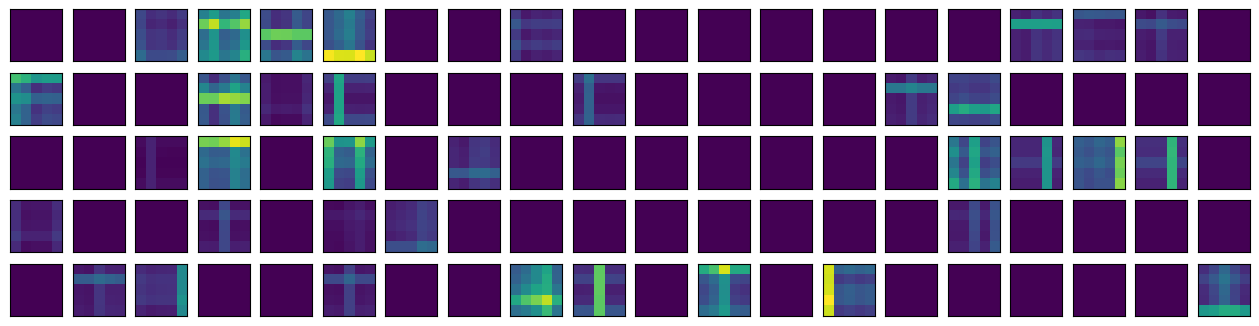

In [21]:
plt.figure(figsize=(16, 4))
for i in range(N_E):
    plt.subplot(5, 20, i + 1)
    plt.imshow(W[i].reshape((N_X, N_X)), vmin=0, vmax=np.max(W))
    #plt.imshow(W_EX[i].reshape((N_X, N_X)))
    plt.xticks([])
    plt.yticks([])